Name: Patrick Ng  
Class: W261-2  
Date: Mar 19, 2016  
HW09

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## HW 9.0: Short answer questions

What is PageRank and what is it used for in the context of web search?  
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady state distibuton?  


#### What is PageRank and what is it used for in the context of web search?  
PageRank is a link analysis algorithm and it assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set.  In the context of web search, it is used for ranking the documents in the posting list of the inverted index, so that relatively more important documents will be put at the beginning of the posting list.  
  
#### What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady state distibuton?  
In order to leverage the machinery of Markov Chains to compute the steady state distibuton, we need to make two adjustments to the webgraph (i.e. the transition matrix H, where each row represents a node):
+ **Stochasticity adjustment** to resolve dangling nodes (nodes with no outbound links) problem:
    + For each zero row we replace each element with 1/n, where n is the number of nodes in the wegraph.
+ **Primitivity adjustment** to guarantee convergence.
    + We need to define a teleport probability $\alpha$ and define the transition matrix as:  
<br/>
\begin{equation} 
P = (1-\alpha)H + {\alpha}I(1/n)  
\end{equation}  
where:  
        - _H_ is the hyperlink matrix
        - n is the number of nodes in the webgraph
        - I is the identity matrix
        
#### OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)  


## HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).  

NOTE: 
+ The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name.  
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:
```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

### Initialize the graph structure based on the adjaceny list file

In [48]:
%%writefile MrInitGraph.py
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrInitGraph(MRJob):

    SORT_VALUES = True  # Need 2nd sort
   
    def mapper(self, _, line):
        # input format:
        # Json object:
        # 1       {'2': 1, '6': 1}
        
        fields = line.strip().split('\t')
        node = fields[0]

        # JSON uses double quote for string
        adjList = json.loads(fields[1].replace("'", '"'))
        
        # Output for the node, which is an outbound node
        yield node, [0, adjList.keys()] # 0 is used for 2nd sorting
        
        # Also need to output an empty entry for every nodes in the adjList.
        # It is needed for directed graph, so that in the reducer we can generate 
        # an entry for nodes which don't have an outbound link.
        for key in adjList.keys():
            yield key, [1]  # 1 is used for 2nd sorting
            
    def reducer(self, node, values):
        value = values.next()
        
        # An outbound node will be seen first because we use 2nd sorting
        if value[0] == 0:
            # It's an outbound record.  
            # Just yield the node without processing the rest of values.
            yield node, [value[1], 0]
        else:
            # In a directed graph, if a node has no outbound link, generate an entry for it.
            # And ignore the rest of values
            yield node, [[], 0]
                                                              
if __name__ == '__main__':
    MrInitGraph.run()

Overwriting MrInitGraph.py


### Calculate the number of nodes

In [46]:
%%writefile MrFindNumberOfNodes.py
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrFindNumberOfNodes(MRJob):
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init, mapper=self.mapper, mapper_final = self.mapper_final,
                   combiner = self.reducer,
                   reducer=self.reducer
            )]

    def mapper_init(self):
        self.partial_size = 0
        
    def mapper(self, _, line):
        self.partial_size += 1
        
    def mapper_final(self):
        yield None, self.partial_size
        
    def reducer(self, key, values):
        yield None, sum(values)
                                                              
if __name__ == '__main__':
    MrFindNumberOfNodes.run()

Overwriting MrFindNumberOfNodes.py


### A PageRank iteration - Job 01 and Job 02

#### Job 01 - Each node distributes its PageRank evenly to all its neighbors

In [80]:
%%writefile MrPageRankJob01.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrPageRankJob01(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    Type_Graph = 0
    Type_PR = 1
    
    Key_LostPR = "#"
    
    def configure_options(self):
        super(MrPageRankJob01, self).configure_options()
        self.add_passthrough_option(
            '--initWithGraphSize', type='int', default=None)

    def mapper_init(self):
        self.lostPR = 0
        
    def mapper(self, node, data):
        adjList, pageRank = data
        
        # We're at the first iteration, and PageRank value hasn't been initialized yet.
        if self.options.initWithGraphSize is not None:
            pageRank = 1 / self.options.initWithGraphSize

        # Pass along the graph structure
        yield node, [self.Type_Graph, adjList]
        
        if len(adjList) > 0:
            # The PR juice we will send out
            p = pageRank / len(adjList)
            for link in adjList:
                yield link, [self.Type_PR, p] # 1 means it's a PR contribution
        else:
            self.lostPR += pageRank
            
    def mapper_final(self):
        yield self.Key_LostPR, self.lostPR

    def reducer(self, node, values):
        pageRank = 0
        if node == self.Key_LostPR:
            yield self.Key_LostPR, sum(values)
        else:
            for value in values:
                valueType, data = value
                if valueType == self.Type_Graph:
                    adjList = data
                else:
                    pageRank += float(data)

            yield node, [adjList, pageRank]
            
                                                              
if __name__ == '__main__':
    MrPageRankJob01.run()

Overwriting MrPageRankJob01.py


#### Job 02 - Update each node's PageRank usng the "lost PR" from last job, and also the 

In [189]:
%%writefile MrPageRankJob02.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrPageRankJob02(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    Key_LostPR = "#"
    
    def configure_options(self):
        super(MrPageRankJob02, self).configure_options()
        self.add_passthrough_option('--graphSize', type=int, default=None)
        self.add_passthrough_option('--lostPR', type=float, default=None)
        self.add_passthrough_option('--teleportRate', type=float, default=None)        

    def mapper(self, node, data):
        if node == self.Key_LostPR:
            return
        
        adjList, pageRank = data

        pageRank = self.options.teleportRate / self.options.graphSize + \
                   (1-self.options.teleportRate) * (self.options.lostPR / self.options.graphSize + pageRank)

        # Pass along the graph structure
        yield node, [adjList, pageRank]                        
                                                              
if __name__ == '__main__':
    MrPageRankJob02.run()

Overwriting MrPageRankJob02.py


#### Sort result according to PageRank

In [232]:
%%writefile MrSortPageRank.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

def toStringKey(n):
    n = int(n)
    digits = len(str(sys.maxint))
    minInt = -sys.maxint - 1

    if n < 0:
        key = "-" + str(abs(minInt-n)).zfill(digits)
    else:
        key = str(n).zfill(digits)

    return key

class MrSortPageRank(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    def configure_options(self):
        super(MrSortPageRank, self).configure_options()
        self.add_passthrough_option('--count', type=int, default=None)
        
    def mapper(self, node, data):
        adjList, pageRank = data
        # Want to sort in descending order.  So use (1-pageRank)
        yield toStringKey((1-pageRank) * 1000000000), [node, pageRank]
        
    def reducer_init(self):
        self.emitted = 0
            
    def reducer(self, _, values):
        
        for value in values:
            if self.emitted == self.options.count:
                return
            
            self.emitted += 1
            yield value[0], value[1]
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer,
                   reducer_init = self.reducer_init,
                    jobconf={
                    "numReduceTasks":"1"}
                  )
        ]
    
if __name__ == '__main__':
    MrSortPageRank.run()

Overwriting MrSortPageRank.py


### Driver for HW91

In [24]:
%%writefile Driver_Hw91.py
from __future__ import division
from MrFindNumberOfNodes import MrFindNumberOfNodes
from MrInitGraph import MrInitGraph
from MrPageRankJob01 import MrPageRankJob01
from MrPageRankJob02 import MrPageRankJob02
from MrSortPageRank import MrSortPageRank
import time
import boto
from boto.s3.key import Key
import mrjob.parse

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--inputFile", type=str)
parser.add_argument("--initGraphPath", type=str, default=None)
parser.add_argument("--outputPath", type=str, default=None)
parser.add_argument("--num-ec2-instances", type=str, default=None)
parser.add_argument("--ec2-instance-type", type=str, default=None)
parser.add_argument("--teleportRate", type=float, default=0.15)
parser.add_argument("--skipInit", action="store_true", help="Don't run initGraph job")
parser.add_argument("--printResult", action="store_true")
parser.add_argument("--nodeCount", type=int, help="Specify nodeCount; for debug purpose")
parser.add_argument("--iteration", type=int, default=5)
parser.add_argument("--resultCount", type=int, default=20, help="Size of sorted result")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--resultFile", type=str, default=None)
parser.add_argument("-r", "--run", type=str)
args = parser.parse_args()

jobArgsBase = ['-r', args.run,
             '--no-strict-protocols']

if args.quiet:
    jobArgsBase += ['-q']

if args.run == "emr":
    jobArgsBase += ["--pool-emr-job-flows"]
    
    if args.ec2_instance_type is not None:
        jobArgsBase += ["--ec2-instance-type", args.ec2_instance_type]
        
    if args.num_ec2_instances is not None:
        jobArgsBase += ["--num-ec2-instances", args.num_ec2_instances]

i = 1
startTime = time.time()

initGraphPath = None
nodeCount = None
outputPath02 = None

def ensureFolderPath(path):
    return path if path.endswith("/") else path + "/"

def printMilestone(s):
    if not args.quiet:
        print s + "  (%.2fs from start)" % (time.time() - startTime)
    
def initGraphStructure():
    global initGraphPath
    
    printMilestone("Init Graph Structure")
    
    # Initialize the graph structure
    jobArgs = [args.inputFile] + jobArgsBase

    if args.run == "inline" or args.run == "local":
        initGraphPath = "initGraph.txt"
        writeOutput = True
    else:
        initGraphPath = ensureFolderPath(args.initGraphPath)
        jobArgs += ["--no-output", "--output-dir", initGraphPath]
        writeOutput = False

    if not args.skipInit:
        mr_jobInitGraph = MrInitGraph(args=jobArgs)
        with mr_jobInitGraph.make_runner() as runner: 
            runner.run()

            if writeOutput:
                # Generate the initGraph file
                with open(initGraphPath, 'w') as f:            
                    for line in runner.stream_output():
                        f.write("%s" % (line))

def findGraphSize():
    global nodeCount
    
    printMilestone("Find Graph Size")
    
    if args.nodeCount is not None:
        # nodeCount already provided.  For debug purpose.
        nodeCount = args.nodeCount
    else:
        # Find the number of nodes
        mr_jobNumberOfNodes = MrFindNumberOfNodes(args=[initGraphPath] + jobArgsBase)
        with mr_jobNumberOfNodes.make_runner() as runner: 
            runner.run()

            for line in runner.stream_output():
                key, value =  mr_jobNumberOfNodes.parse_output_line(line)
                nodeCount = int(value)

    printMilestone("Number of nodes = %d" % (nodeCount))

def readLostPRFromS3(outputPath):
    # Read the lost PR from one of the output file.  We will read the beginning portion of each file
    # and see if we can find that special lost PR key.

    s3_connection = boto.connect_s3()

    assert mrjob.parse.is_s3_uri(outputPath)
    bucket, key = mrjob.parse.parse_s3_uri(outputPath)
    bucket = s3_connection.get_bucket(bucket)
    pattern = key + 'part-'

    for key in s3_connection.get_bucket(bucket):
        #print 'key.name=', key.name

        # ignore the file we don't care
        if not key.name.startswith(pattern):
            continue

        content = key.get_contents_as_string(headers={'Range' : 'bytes=0-100'})
        content = content.partition("\n")[0] # Get the first line

        fields = content.split('\t')
        if fields[0] == '"' + MrPageRankJob01.Key_LostPR + '"':
            assert len(fields) == 2
            lostPR = float(fields[1])
            return lostPR
    
    assert False, "lostPR isn't found"

def runPageRank(iterations):
    global outputPath02
    graphInited = False

    for i in range(1, iterations+1):
        # Run MrPageRankJob01
        printMilestone("Iteration %02d-1" % i)

        if i == 1:
            inputPath = initGraphPath
        else:
            inputPath = outputPath02 # from job02 in last iteration

        jobArgs = [inputPath] + jobArgsBase
        if args.run == "inline" or args.run == "local":
            outputPath01 = "output-%02d-1.txt" % i
            writeOutput = True
        else:
            outputPath01 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-1/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath01] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        if not graphInited:
            jobArgs += ["--initWithGraphSize", str(nodeCount)]
            graphInited = True

        # Run Job 01 - each node distribute its PageRank to all its neighbors
        mr_jobPageRankJob01 = MrPageRankJob01(args=jobArgs)
        with mr_jobPageRankJob01.make_runner() as runner: 
            runner.run()

            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath01, 'w')

                for line in runner.stream_output():
                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    if key == MrPageRankJob01.Key_LostPR:
                        lostPR = float(value)
                    else:
                        if writeOutput:
                            f.write(line)
                            
                        #if args.printResult:
                        #    print line.strip()


                if writeOutput:
                    f.close()

            else:
                time.sleep(5) # Sleep a bit for S3 consistency
                lostPR = readLostPRFromS3(outputPath01)


        # Run Job 02 - Distribute the lost PR and also the teleported PageRank
        jobArgs = [outputPath01] + jobArgsBase

        if args.run == "inline" or args.run == "local":
            outputPath02 = "output-%02d-2.txt" % i
            writeOutput = True
        else:
            outputPath02 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-2/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath02] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        jobArgs += ['--graphSize', str(nodeCount), '--lostPR', str(lostPR), 
                    '--teleportRate', str(args.teleportRate)]

        printMilestone("Iteration: %02d-2" % i)
        mr_jobPageRankJob02 = MrPageRankJob02(args=jobArgs)
        with mr_jobPageRankJob02.make_runner() as runner: 
            totalPR = 0
            runner.run()
            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath02, 'w')

                for line in runner.stream_output():
                    if writeOutput:
                        f.write(line)

                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    totalPR += float(value[1])

                    if args.printResult:
                        print line.strip()

                if writeOutput:
                    f.close()

        if args.printResult:
            print

def outputSortedResult(resultCount, resultPath):

    # Run MrPageRankJob01
    printMilestone("Output Sorted Result:")

    jobArgs = [resultPath] + jobArgsBase

    # Run Job 01 - each node distribute its PageRank to all its neighbors
    mr_job = MrSortPageRank(args=jobArgs)
    
    resultFile = args.resultFile
    if args.resultFile is None:
        resultFile = "result-%s.txt" % args.run
        
    with mr_job.make_runner() as runner: 
        runner.run()

        with open(resultFile, "w") as f:
            for line in runner.stream_output():
                f.write(line)
                
    return resultFile

# The flow

initGraphStructure()
findGraphSize()
runPageRank(args.iteration)
fn = outputSortedResult(args.resultCount, outputPath02)

if not args.quiet:
    print
    print "Total result location:", outputPath02
    print "Sorted result location:", fn
    print
    print "Total time: %.3fs" % (time.time() - startTime)

Overwriting Driver_Hw91.py


In [24]:
%%writefile Driver_Hw91.py
from __future__ import division
from MrFindNumberOfNodes import MrFindNumberOfNodes
from MrInitGraph import MrInitGraph
from MrPageRankJob01 import MrPageRankJob01
from MrPageRankJob02 import MrPageRankJob02
from MrSortPageRank import MrSortPageRank
import time
import boto
from boto.s3.key import Key
import mrjob.parse
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--inputFile", type=str)
parser.add_argument("--initGraphPath", type=str, default=None)
parser.add_argument("--outputPath", type=str, default=None)
parser.add_argument("--num-ec2-instances", type=str, default=None)
parser.add_argument("--ec2-instance-type", type=str, default=None)
parser.add_argument("--teleportRate", type=float, default=0.15)
parser.add_argument("--skipInit", action="store_true", help="Don't run initGraph job")
parser.add_argument("--printResult", action="store_true")
parser.add_argument("--nodeCount", type=int, help="Specify nodeCount; for debug purpose")
parser.add_argument("--iteration", type=int, default=5)
parser.add_argument("--resultCount", type=int, default=20, help="Size of sorted result")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--resultFile", type=str, default=None)
parser.add_argument("-r", "--run", type=str)
args = parser.parse_args()

jobArgsBase = ['-r', args.run,
             '--no-strict-protocols']

if args.quiet:
    jobArgsBase += ['-q']

if args.run == "emr":
    jobArgsBase += ["--pool-emr-job-flows"]
    
    if args.ec2_instance_type is not None:
        jobArgsBase += ["--ec2-instance-type", args.ec2_instance_type]
        
    if args.num_ec2_instances is not None:
        jobArgsBase += ["--num-ec2-instances", args.num_ec2_instances]

i = 1
startTime = time.time()

initGraphPath = None
nodeCount = None
outputPath02 = None

def ensureFolderPath(path):
    return path if path.endswith("/") else path + "/"

def printMilestone(s):
    if not args.quiet:
        print s + "  (%.2fs from start)" % (time.time() - startTime)
    
def initGraphStructure():
    global initGraphPath
    
    printMilestone("Init Graph Structure")
    
    # Initialize the graph structure
    jobArgs = [args.inputFile] + jobArgsBase

    if args.run == "inline" or args.run == "local":
        initGraphPath = "initGraph.txt"
        writeOutput = True
    else:
        initGraphPath = ensureFolderPath(args.initGraphPath)
        jobArgs += ["--no-output", "--output-dir", initGraphPath]
        writeOutput = False

    if not args.skipInit:
        mr_jobInitGraph = MrInitGraph(args=jobArgs)
        with mr_jobInitGraph.make_runner() as runner: 
            runner.run()

            if writeOutput:
                # Generate the initGraph file
                with open(initGraphPath, 'w') as f:            
                    for line in runner.stream_output():
                        f.write("%s" % (line))

def findGraphSize():
    global nodeCount
    
    printMilestone("Find Graph Size")
    
    if args.nodeCount is not None:
        # nodeCount already provided.  For debug purpose.
        nodeCount = args.nodeCount
    else:
        # Find the number of nodes
        mr_jobNumberOfNodes = MrFindNumberOfNodes(args=[initGraphPath] + jobArgsBase)
        with mr_jobNumberOfNodes.make_runner() as runner: 
            runner.run()

            for line in runner.stream_output():
                key, value =  mr_jobNumberOfNodes.parse_output_line(line)
                nodeCount = int(value)

    printMilestone("Number of nodes = %d" % (nodeCount))

def readLostPRFromS3(outputPath):
    # Read the lost PR from one of the output file.  We will read the beginning portion of each file
    # and see if we can find that special lost PR key.

    s3_connection = boto.connect_s3()

    assert mrjob.parse.is_s3_uri(outputPath)
    bucket, key = mrjob.parse.parse_s3_uri(outputPath)
    bucket = s3_connection.get_bucket(bucket)
    pattern = key + 'part-'

    for key in s3_connection.get_bucket(bucket):
        #print 'key.name=', key.name

        # ignore the file we don't care
        if not key.name.startswith(pattern):
            continue

        content = key.get_contents_as_string(headers={'Range' : 'bytes=0-100'})
        content = content.partition("\n")[0] # Get the first line

        fields = content.split('\t')
        if fields[0] == '"' + MrPageRankJob01.Key_LostPR + '"':
            assert len(fields) == 2
            lostPR = float(fields[1])
            return lostPR
    
    assert False, "lostPR isn't found"

def runPageRank(iterations):
    global outputPath02
    graphInited = False

    for i in range(1, iterations+1):
        # Run MrPageRankJob01
        printMilestone("Iteration %02d-1" % i)

        if i == 1:
            inputPath = initGraphPath
        else:
            inputPath = outputPath02 # from job02 in last iteration

        jobArgs = [inputPath] + jobArgsBase
        if args.run == "inline" or args.run == "local":
            outputPath01 = "output-%02d-1.txt" % i
            writeOutput = True
        else:
            outputPath01 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-1/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath01] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        if not graphInited:
            jobArgs += ["--initWithGraphSize", str(nodeCount)]
            graphInited = True

        # Run Job 01 - each node distribute its PageRank to all its neighbors
        mr_jobPageRankJob01 = MrPageRankJob01(args=jobArgs)
        with mr_jobPageRankJob01.make_runner() as runner: 
            runner.run()

            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath01, 'w')

                for line in runner.stream_output():
                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    if key == MrPageRankJob01.Key_LostPR:
                        lostPR = float(value)
                    else:
                        if writeOutput:
                            f.write(line)
                            
                        #if args.printResult:
                        #    print line.strip()


                if writeOutput:
                    f.close()

            else:
                time.sleep(5) # Sleep a bit for S3 consistency
                lostPR = readLostPRFromS3(outputPath01)


        # Run Job 02 - Distribute the lost PR and also the teleported PageRank
        jobArgs = [outputPath01] + jobArgsBase

        if args.run == "inline" or args.run == "local":
            outputPath02 = "output-%02d-2.txt" % i
            writeOutput = True
        else:
            outputPath02 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-2/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath02] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        jobArgs += ['--graphSize', str(nodeCount), '--lostPR', str(lostPR), 
                    '--teleportRate', str(args.teleportRate)]

        printMilestone("Iteration: %02d-2" % i)
        mr_jobPageRankJob02 = MrPageRankJob02(args=jobArgs)
        with mr_jobPageRankJob02.make_runner() as runner: 
            totalPR = 0
            runner.run()
            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath02, 'w')

                for line in runner.stream_output():
                    if writeOutput:
                        f.write(line)

                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    totalPR += float(value[1])

                    if args.printResult:
                        print line.strip()

                if writeOutput:
                    f.close()

        if args.printResult:
            print

def outputSortedResult(resultCount, resultPath):

    # Run MrPageRankJob01
    printMilestone("Output Sorted Result:")

    jobArgs = [resultPath] + jobArgsBase

    # Run Job 01 - each node distribute its PageRank to all its neighbors
    mr_job = MrSortPageRank(args=jobArgs)
    
    resultFile = args.resultFile
    if args.resultFile is None:
        resultFile = "result-%s.txt" % args.run
        
    with mr_job.make_runner() as runner: 
        runner.run()

        with open(resultFile, "w") as f:
            for line in runner.stream_output():
                f.write(line)
                
    return resultFile

# The flow

initGraphStructure()
findGraphSize()
runPageRank(args.iteration)
fn = outputSortedResult(args.resultCount, outputPath02)

if not args.quiet:
    print
    print "Total result location:", outputPath02
    print "Sorted result location:", fn
    print
    print "Total time: %.3fs" % (time.time() - startTime)

Overwriting Driver_Hw91.py


In [25]:
!rm -f output.txt
!rm -f initGraph.txt

!python Driver_Hw91.py -r inline \
--inputFile PageRank-test.txt \
--iteration 3 


Init Graph Structure  (0.00s from start)
No handlers could be found for logger "mrjob.sim"
Find Graph Size  (0.06s from start)
Number of nodes = 11  (0.10s from start)
Iteration 01-1  (0.10s from start)
Iteration: 01-2  (0.14s from start)
Iteration 02-1  (0.16s from start)
Iteration: 02-2  (0.19s from start)
Iteration 03-1  (0.21s from start)
Iteration: 03-2  (0.25s from start)
Output Sorted Result:  (0.27s from start)

Total result location: output-03-2.txt
Sorted result location: result-inline.txt

Total time: 0.300s


In [22]:
!cat result-inline.txt

"B"	0.40729180730104886
"C"	0.23815584801812978
"E"	0.11821894280902044
"A"	0.0640190695933832
"D"	0.0447357013030419
"F"	0.0447357013030419
"G"	0.016568585934478637
"H"	0.016568585934478637
"I"	0.016568585934478637
"J"	0.016568585934478637
"K"	0.016568585934478637


#### Test it on Hadoop

In [4]:
!hdfs dfs -rm -r hw91
!hdfs dfs -mkdir hw91

!python Driver_Hw91.py -r hadoop \
--inputFile PageRank-test.txt \
--initGraphPath hdfs://127.0.0.1/user/patrickng/hw91/init/ \
--outputPath hdfs://127.0.0.1/user/patrickng/hw91/output/ \
--iteration 3 
    

16/03/13 19:25:35 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw91
16/03/13 19:25:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Init Graph Structure  (0.00s from start)
No handlers could be found for logger "mrjob.compat"
Find Graph Size  (42.91s from start)
Number of nodes = 11

Iteration 01-1  (86.91s from start)
Iteration: 01-2  (132.21s from start)
Iteration 02-1  (168.93s from start)
Iteration: 02-2  (212.81s from start)
Iteration 03-1  (248.57s from start)
Iteration: 03-2  (290.08s from start)
Output Sorted Result:  (327.64s from start)


Total result location: hdfs://127.0.0.1/user/patrickng/hw91/output/iter3-2/
Sorted result location: result-hadoop.txt

Total time: 368.489s


In [5]:
!cat result-hadoop.txt

"B"	0.40729180730104886
"C"	0.23815584801812972
"E"	0.11821894280902044
"A"	0.0640190695933832
"D"	0.0447357013030419
"F"	0.0447357013030419
"K"	0.016568585934478637
"J"	0.016568585934478637
"I"	0.016568585934478637
"H"	0.016568585934478637
"G"	0.016568585934478637


#### Test it on EMR

In [6]:
!aws s3 mb s3://patng323-w261-hw91
!aws s3 cp PageRank-test.txt s3://patng323-w261-hw91/input/
!aws s3 ls s3://patng323-w261-hw91/input/

make_bucket: s3://patng323-w261-hw91/
upload: ./PageRank-test.txt to s3://patng323-w261-hw91/input/PageRank-test.txt
2016-03-13 19:33:27        166 PageRank-test.txt


In [7]:
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw91/init
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw91/output
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python Driver_Hw91.py -r emr \
--inputFile PageRank-test.txt \
--initGraphPath s3://patng323-w261-hw91/init \
--outputPath s3://patng323-w261-hw91/output \
--num-ec2-instances 2 \
--ec2-instance-type m1.medium \
--iteration 3


delete: s3://patng323-w261-hw91/init/_SUCCESS
delete: s3://patng323-w261-hw91/init/part-00000  
delete: s3://patng323-w261-hw91/output/iter1-1/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter2-2/part-00000
delete: s3://patng323-w261-hw91/output/iter2-2/part-00001
delete: s3://patng323-w261-hw91/output/iter1-1/part-00000
delete: s3://patng323-w261-hw91/output/iter1-2/part-00002
delete: s3://patng323-w261-hw91/output/iter2-2/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter1-2/part-00001
delete: s3://patng323-w261-hw91/output/iter1-2/part-00000
delete: s3://patng323-w261-hw91/output/iter1-2/part-00003
delete: s3://patng323-w261-hw91/output/iter2-1/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter2-2/part-00002
delete: s3://patng323-w261-hw91/output/iter1-2/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter2-1/part-00000
delete: s3://patng323-w261-hw91/output/iter3-1/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter3-2/_SUCCESS
delete: s3://patng323-w261-hw91/output/iter3-1

In [8]:
!cat result-emr.txt

"B"	0.4072918073010488
"C"	0.23815584801812978
"E"	0.11821894280902044
"A"	0.064019069593383202
"D"	0.0447357013030419
"F"	0.0447357013030419
"G"	0.016568585934478637
"H"	0.016568585934478637
"I"	0.016568585934478637
"J"	0.016568585934478637
"K"	0.016568585934478637


## HW 9.2: Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied.   

Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].  

Note your plots should look like the following:  
https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [33]:
import json
import sys
import subprocess
import os

dampingFactors = [0,0.25,0.5,0.75, 0.85, 1]

for i, df in zip(range(len(dampingFactors)), dampingFactors):
    resultFile = "result-%s.txt" % str(i)
                 
    commands = "cd %s; " % os.getcwd()
    commands += "rm -f output.txt; "
    commands += "rm -f initGraph.txt; "
    commands += "rm -f %s; " % resultFile

    commands += ("python Driver_Hw91.py -r inline "
                 "--inputFile PageRank-test.txt "
                 "--iteration 30 "
                 "--teleportRate %f "
                 "--quiet "
                 "--resultFile %s" % (1-df, resultFile))
                 
    subprocess.check_call(commands, shell=True)

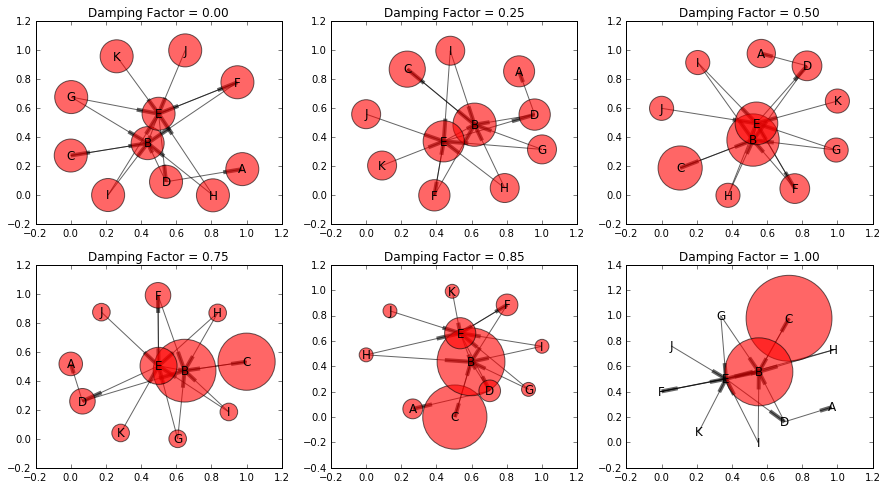

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

with open("PageRank-test.txt", "r") as f:
    for line in f:
        fields = line.strip().split('\t')
        node = fields[0]
        adjList = json.loads(fields[1].replace("'", '"'))

        G.add_node(node)

        for k in adjList.keys():
            G.add_edge(node, k)

fig, axis_arr = plt.subplots(2,3,figsize=(15,8))

for i, df in zip(range(len(dampingFactors)), dampingFactors):
    resultFile = "result-%s.txt" % str(i)

    pageRanks = {}
    sizes = []

    with open(resultFile) as f:
        for line in f:
            fields = line.strip().split('\t')
            node = fields[0].replace('"', '')
            pageRanks[node] = float(fields[1])

    for n in G.nodes():
        sizes.append(pageRanks[n] * 300 * 40)

    ax = axis_arr.flatten()[i]
    ax.set_title('Damping Factor = %.2f' % df)
    nx.draw_networkx(G, with_labels=True, ax = ax, node_size = sizes, alpha=0.6)
    
plt.show()